In [609]:
%%capture

import warnings
warnings.filterwarnings('ignore')

# External libraries
import pandas as pd
import nltk
from nltk.corpus import wordnet
import re
import string
import random
import numpy as np
import importlib
#import splitter

# My Files
import transition_matrix as tm
import caption
import scorer

# Ensure files are latest version
importlib.reload(tm)
importlib.reload(caption)
importlib.reload(scorer)


# nltk downloads
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')


In [610]:
img_file = "./images/abstract.jpeg"

In [611]:
cmudict = nltk.corpus.cmudict
phoneme_dict = dict(cmudict.entries())

In [612]:

"""
Credit: hauntsaninja @ https://datascience.stackexchange.com/questions/23376/how-to-get-the-number-of-syllables-in-a-word
""" 

VOWEL_RUNS = re.compile("[aeiouy]+", flags=re.I)
EXCEPTIONS = re.compile(
    # fixes trailing e issues:
    # smite, scared
    "[^aeiou]e[sd]?$|"
    # fixes adverbs:
    # nicely
    + "[^e]ely$",
    flags=re.I
)
ADDITIONAL = re.compile(
    # fixes incorrect subtractions from exceptions:
    # smile, scarred, raises, fated
    "[^aeioulr][lr]e[sd]?$|[csgz]es$|[td]ed$|"
    # fixes miscellaneous issues:
    # flying, piano, video, prism, fire, evaluate
    + ".y[aeiou]|ia(?!n$)|eo|ism$|[^aeiou]ire$|[^gq]ua",
    flags=re.I
)

def count_syllables_custom(word):
    vowel_runs = len(VOWEL_RUNS.findall(word))
    exceptions = len(EXCEPTIONS.findall(word))
    additional = len(ADDITIONAL.findall(word))
    return max(1, vowel_runs - exceptions + additional)

# Count syllables in word using nltk with custom fallback (courtesy @hautsaninja on StackExchange)

def count_syllables(word):
    if word in phoneme_dict:   
        return len([ph for ph in phoneme_dict[word] if ph.strip(string.ascii_letters)])
    elif not word.isalpha():
        return 0
    else:
        res = count_syllables_custom(word)
        return res

In [613]:
sentences, scores = caption.get_caption(img_file)
scores = [float(s) for s in scores]

In [614]:
sentences_and_scores = sorted(zip(scores, sentences))[::-1]
maxProb = 0.9
discount = 0.7
prob = maxProb

words = []
for _, s in sentences_and_scores:
    for w in s:
        if w in ["<start>", "<end>"]:
            continue
        if random.uniform(0,1) >= prob:
            words.append(w)
    prob *= discount

In [615]:
text = nltk.word_tokenize(" ".join(words))
tagged_text = nltk.pos_tag(text)

# https://stackoverflow.com/questions/15388831/what-are-all-possible-pos-tags-of-nltk list of tag meanings
acceptable = ['NN', 'JJ', 'JJR', 'JJS' , 'NNS', 'PRP', 'RB', 'RBR', 'RBS', 'VB', 'RP', 'VBD', 'VBG', 'VBN', 'VBP']

#acceptable_words = [w if t in acceptable else None for w, t in tagged_text]
acceptable_words = list(filter(lambda c: c[1]  in acceptable, tagged_text))
acceptable_words = {w for w, _ in acceptable_words}

In [616]:
num_words = min(3, len(acceptable_words) - 1)
words = random.sample(range(0, len(acceptable_words)), num_words)
final_words = np.array(list(acceptable_words))
final_words = list(final_words[words])
final_words

['holding', 'front', 'are']

# Generate Line One

In [617]:
def get_first_line_start(word, start_symbol = "startlinehere"):
    starts = []
    PoetryMatrix.SparseMatrix.items()

In [618]:
#for k,v in PoetryMatrix.SparseMatrix.items():
#    print(k)
#    print(v)
#    break

In [619]:
def generate_candidate_lines(start_word, end_words, max_paths = [5, 10, 15, 20, 25], random_start = True):
    print("Start word : {}".format(start_word))
    stemmer = nltk.stem.snowball.PorterStemmer()
    used_starts = [start_word]
    if random_start:
        starts = []
        start_word_stem = stemmer.stem(start_word) 
        print("Stem word : {}".format(start_word_stem))
        tries = 0
        while len(starts) == 0 and tries < 3:
            for k,v in PoetryMatrix.SparseMatrix.items():
                if (k.split(',')[0] in ["endlinehere", "startlinehere", "lineendhere"] and start_word_stem in k.split(',')[1]):
                    starts.append(k)
            for k,v in PoetryMatrix.SparseMatrix.items():
                if start_word_stem in k.split(',')[0] or start_word_stem in k.split(',')[1]:
                    starts.append(k)
            if len(starts) > 0:
                break
            wsyn = wordnet.synsets(start_word)
            for syn in wsyn:
                for l in syn.lemmas():
                    if not l.name().isalpha():
                        continue
                    synsc = l.name()
                    print("Potential New word {}".format(l.name()))
                    if synsc not in used_starts:
                        start_word = synsc
                        print("New word {}".format(synsc))
                        used_starts += [start_word]
                        start_word_stem = stemmer.stem(start_word)
                        break
            tries+=1
        if len(starts) == 0:
            print("ZERO CANDIDATES!")
            for k,_ in PoetryMatrix.SparseMatrix.items():
                starts.append(k)
        idx = random.randint(0, len(starts) - 1)
    else:
        idx = 0
        starts = [start_word]

    paths = []
    
    for max_path in max_paths:
        path = [*starts[idx].split(",")]
        print("Starting path: {}".format(path))
        if random_start:
            idx = random.randint(0, len(starts) - 1)
        for i in range(9):
            next_word = PoetryMatrix.next_word(path[-2], path[-1])
            path += [next_word]
        tmp = []
        if "," in path[0]:
            w1, w2 = path[0].split(",")
            path = [w1, w2, *path[1:]]
        for w in path:
            if w not in ["endlinehere", "startlinehere", "lineendhere"]:
                tmp.append(w)
        paths.append(tmp)
    return paths


In [620]:


def fix_line(input_path, desired_syllables, no_words, end_symbols, matrix, prev = ["startlinehere", "endlinehere"]):
    
    """
    # Check if no path found, and choose random path
    if type(input_path[0]) is not str:
        new_sample = random.randint(0, len(input_path))
        path = input_path[new_sample]['nodes']
    else:
        path = input_path
    """
    path = input_path
    sentence = path
    
    """
    # Remove unwanted words (i.e. conditioned input or special symbols)
    for word in no_words:
        try:
            sentence.remove(word)
        except:
            continue
    """
    
    next_line = []

    sentence = []
    
    for w in path:
        if w not in ["endlinehere", "startlinehere", "lineendhere"]:
            sentence.append(w)
    
    if len(sentence) > desired_syllables:
        print("Too many tokens. Bumping end to next line...")
        while len(sentence) > desired_syllables:
            next_line = [sentence[-1]] + next_line
            sentence = sentence[:-1]


    line_syllables = 0
    
    # Count syllables
    for word in sentence:
        line_syllables += count_syllables(word)
        
        
        
        
    if line_syllables > desired_syllables:
        print("TOO LONG: Bumping last words")
        while line_syllables > desired_syllables:
            first_w_s = count_syllables(sentence[-1])
            next_line = [sentence[-1]] + next_line
            sentence = sentence[:-1]
            line_syllables -= first_w_s
        
        
    
    # Add a word if there are only 0 or 1 words
    if len(sentence) == 0:
        print("Line size 0! Adding word...")
        next_word = matrix.next_word(prev[-2], prev[-1])
        while next_word in ["endlinehere", "startlinehere", "lineendhere"]:
            next_word = matrix.next_word(prev[-2], prev[-1])
        sentence.append(next_word)
        line_syllables += count_syllables(next_word) 
    if len(sentence) == 1:
        print("Line size 1! Adding word...")
        next_word = matrix.next_word(prev[-1],sentence[0])
        while next_word in ["endlinehere", "startlinehere", "lineendhere"]:
            next_word = matrix.next_word(prev[-2], prev[-1])
        sentence.append(next_word)
        line_syllables += count_syllables(next_word) 
        
        
    # Replace words with synonyms to increase syllables if necessary
    if line_syllables < desired_syllables:
        print("Increasing line size with synonyms...")
        difference = line_syllables - desired_syllables
        #print(sentence)
        for i in range(len(sentence) - 2):
            w = sentence[i]
            sc = count_syllables(w)
            wsyn = wordnet.synsets(w)
            replaced = False
            for syn in wsyn:
                if replaced == True:
                    break
                for l in syn.lemmas():
                    if not l.name().isalpha():
                        continue
                    synsc = count_syllables(l.name())
                    if synsc > sc:
                        print('replaceing {} with {}. {} -> {}'.format(sentence[i], l.name(), count_syllables(sentence[i]), count_syllables(l.name())))
                        sentence[i] = l.name()
                        print("{} --> {} - {} + {} = {}".format(line_syllables, line_syllables, sc, synsc, (line_syllables - sc) + synsc))
                        line_syllables = (line_syllables - sc) + synsc
                        if line_syllables == desired_syllables:
                            return sentence, [matrix.next_word(sentence[-2], sentence[-1])]
                        replaced = True
                        break
            if line_syllables == desired_syllables:
                break
        if line_syllables < desired_syllables:
            if len(sentence) == 0:
                next_word = matrix.next_word(path[0].split(",")[0],path[0].split(",")[1])
            elif len(sentence) == 1:
                next_word = matrix.next_word(path[0].split(",")[1],path[1])
            else:
                next_word = matrix.next_word(sentence[-2],sentence[-1])
            sentence.append(next_word)
            line_syllables += count_syllables(next_word)
        

    # Add words to increase syllables if necessary        TODO: is this unused now??
    if line_syllables < desired_syllables:
        print("Increasing line size by adding words...")
    while line_syllables < desired_syllables:
        if len(sentence) == 0:
            next_word = matrix.next_word(path[0].split(",")[0],path[0].split(",")[1])
        elif len(sentence) == 1:
            next_word = matrix.next_word(path[0].split(",")[1],path[1])
        else:
            next_word = matrix.next_word(sentence[-2],sentence[-1])
        if next_word not in ["endlinehere", "startlinehere", "lineendhere"]:
            sentence.append(next_word)
            line_syllables += count_syllables(next_word)
        #print(sentence)
        
    # Replace words with synonyms to decrease syllables if necessary
    if line_syllables > desired_syllables:
        print("Decreasing line size with synonyms...")
        difference = line_syllables - desired_syllables
        for i in range(len(sentence)):
            w = sentence[i]
            sc = count_syllables(w)
            if sc > 1:
                wsyn = wordnet.synsets(w)
                replaced = False
                for syn in wsyn:
                    if replaced == True:
                        break
                    for l in syn.lemmas():
                        if not l.name().isalpha():
                            continue
                        synsc = count_syllables(l.name())
                        if synsc < sc:
                            print('replaceing {} with {}. {} -> {}'.format(sentence[i], l.name(), count_syllables(sentence[i]), count_syllables(l.name())))
                            sentence[i] = l.name()
                            print("{} --> {} - {} + {} = {}".format(line_syllables, line_syllables, sc, synsc, (line_syllables - sc) + synsc))
                            line_syllables = (line_syllables - sc) + synsc
                            if line_syllables == desired_syllables:
                                return sentence, [matrix.next_word(sentence[-2], sentence[-1])]
                            replaced = True
                            break
    
    
    attempts = 1000
    # Add words to increase syllables if necessary        TODO: is this unused now??
    if line_syllables < desired_syllables:
        print("Increasing line size by adding words...")
    while line_syllables < desired_syllables and attempts > 0:
        if len(sentence) == 0:
            next_word = matrix.next_word(path[0].split(",")[0],path[0].split(",")[1])
        elif len(sentence) == 1:
            next_word = matrix.next_word(path[0].split(",")[1],path[1])
        else:
            next_word = matrix.next_word(sentence[-2],sentence[-1])
        if next_word not in ["endlinehere", "startlinehere", "lineendhere"]:
            sc = count_syllables(next_word)
            if line_syllables + sc <= desired_syllables:
                sentence.append(next_word)
                line_syllables += sc
        attempts -= 1
        
        
    
    if line_syllables > desired_syllables:
        print("TOO LONG: Bumping last words")
        while line_syllables > desired_syllables:
            first_w_s = count_syllables(sentence[-1])
            next_line = [sentence[-1]] + next_line
            sentence = sentence[:-1]
            line_syllables -= first_w_s
            
            
    # Ignore next_line
    return sentence, []

In [621]:
start_symbols = ("endlinehere", "startlinehere")
poem_file = "./data/poems_selected_start_end_punc_breaks.txt"
prohibited = [*start_symbols]
line_length = 10 # syllables
end_symbols = [*final_words] # TODO add all words, add synonyms from word2vec to solve no path found

PoetryMatrix = tm.get_matrix(poem_file)

Processing ./data/poems_selected_start_end_punc_breaks.txt


In [622]:
candidate_lines_1 = generate_candidate_lines(end_symbols[0], end_symbols[1:])

Start word : holding
Stem word : hold
Starting path: ['to', 'uphold']
Starting path: ['hold', 'him']
Starting path: ['beholding', 'god']
Starting path: ['can', 'hold']
Starting path: ['lineendhere', 'behold']


In [623]:
line_one, next_line = fix_line(candidate_lines_1[0], 5, candidate_lines_1[0][0], [], PoetryMatrix)
print(line_one)

Too many tokens. Bumping end to next line...
TOO LONG: Bumping last words
['to', 'uphold', 'him', 'and']


In [624]:
candidate_lines_2 = []
if next_line:
    if len(next_line) >= 2:
        candidate_lines_2 = generate_candidate_lines("{},{}".format(next_line[0], next_line[1]), end_symbols[2:], random_start = False)
    else:
        candidate_lines_2_temp = generate_candidate_lines("{},{}".format(line_one[-1], next_line[0]), end_symbols[2:])
        for tmp_line in candidate_lines_2_temp:
            candidate_lines_2.append(tmp_line[1:])
    print(candidate_lines_2)
    if len(candidate_lines_2) < 1:
        candidate_lines_2.append(next_line)
    line_two, next_line = fix_line(candidate_lines_2[0],
                                   7,
                                   candidate_lines_2[0][0],
                                   [],
                                   PoetryMatrix,
                                   prev = line_one[-2:])
else:
    candidate_lines_2 = generate_candidate_lines(end_symbols[1], ["endlinehere", "lineendhere"])
    line_two, next_line = fix_line(candidate_lines_2[0], 7, candidate_lines_2[0][0], [], PoetryMatrix, prev = line_one[-2:])
    
    

Start word : front
Stem word : front
Starting path: ['the', 'front']
Starting path: ['pubs', 'front']
Starting path: ['fronted', 'him']
Starting path: ['front', 'of']
Starting path: ['front', 'there']


In [625]:
if next_line:
    if len(next_line) >= 2:
        candidate_lines_3 = generate_candidate_lines("{},{}".format(next_line[0], next_line[1]), ["endlinehere", "lineendhere", *end_symbols[3:]], random_start = False)
    else:
        candidate_lines_3_temp = generate_candidate_lines("{},{}".format(line_two[-1], next_line[0]), ["endlinehere", "lineendhere", *end_symbols[3:]], random_start = False)
        candidate_lines_3 = []
        for tmp_line in candidate_lines_3_temp:
            candidate_lines_3.append(tmp_line[1:])
    line_three, next_line = fix_line(candidate_lines_3[0], 5, candidate_lines_3[0][0], [], PoetryMatrix, prev = line_two[-2:])
else:
    candidate_lines_3 = generate_candidate_lines(end_symbols[2], ["endlinehere", "lineendhere", *end_symbols[3:]])
    line_three, next_line = fix_line(candidate_lines_3[0], 5, candidate_lines_3[0][0], [], PoetryMatrix, prev = line_two[-2:])

Start word : are
Stem word : are
Starting path: ['grass', 'are']
Starting path: ['honour', 'are']
Starting path: ['sage', 'parent']
Starting path: ['and', 'compare']
Starting path: ['budapest', 'square']
Too many tokens. Bumping end to next line...


In [626]:
print(candidate_lines_3)
line_three, next_line = fix_line(candidate_lines_3[0], 5, candidate_lines_3[0][0], [], PoetryMatrix, prev = line_two[-2:])
print(line_three)
print(next_line)

[['grass', 'are', 'drawing', 'out', '!', 'winter', 'bleak'], ['honour', 'are', 'seas', 'and', 'cities', 'near', 'and', 'far', 'from', 'home'], ['sage', 'parent', '.', 'if', 'holy', 'mother', 'you'], ['and', 'compare', 'fountain', 'pens', 'friend', 'do', 'you'], ['budapest', 'square', 'he', 'spoke', 'for', 'nobody']]
Too many tokens. Bumping end to next line...
['grass', 'are', 'drawing', 'out', '!']
[]


In [627]:
tagged_l3 = nltk.pos_tag(line_three)
bad_pos = ["IN", "DT", "MD", "TO", "CC"]
if tagged_l3[-1][1] in bad_pos:
    line_three_short = line_three[:-1]
    print(line_three_short)
    line_three, _ = fix_line(line_three_short, 5, line_three_short[0], [], PoetryMatrix, prev = line_two[-2:])
print(line_three)

['grass', 'are', 'drawing', 'out', '!']


In [628]:
print(line_one)
print(line_two)
print(line_three)

['to', 'uphold', 'him', 'and']
['the', 'front', 'reins', '.', 'no', 'challenge', 'screamed']
['grass', 'are', 'drawing', 'out', '!']


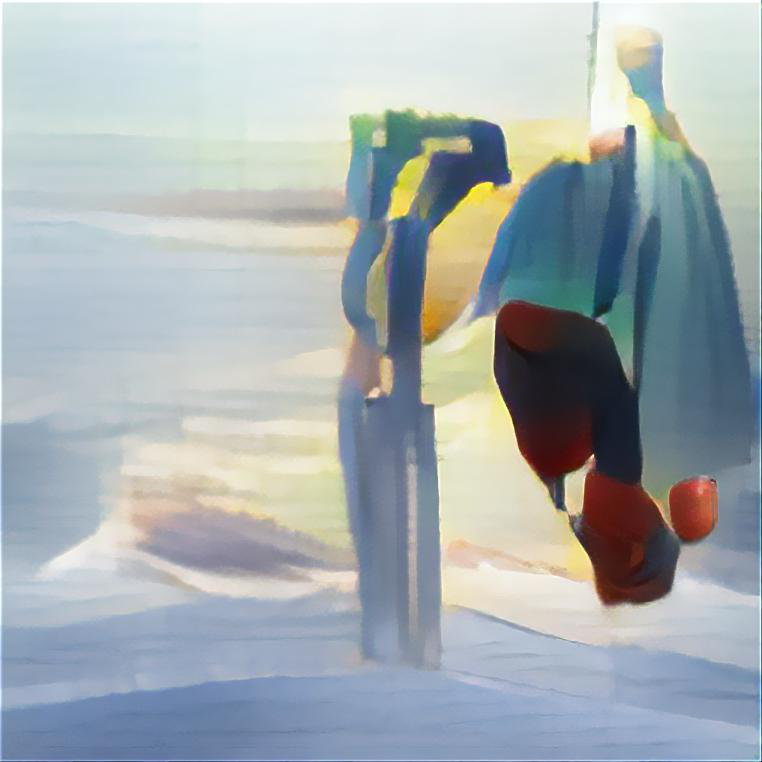

to uphold him and
the front reins . no challenge screamed
grass are drawing out !


In [629]:
from IPython.display import display
from PIL import Image
display(Image.open(img_file))
print(" ".join(line_one))
print(" ".join(line_two))
print(" ".join(line_three))

In [630]:
#for s, l in sentences_and_scores:
#    print("{}: {}".format(s, " ".join(l)))

In [631]:
word_score, image_score, haiku_image, seed_image = scorer.score_haiku(" ".join([*line_one, *line_two, *line_three]),acceptable_words, img_file)

['<start>', 'a', 'bunch', 'of', 'cell', 'phones', 'sitting', 'on', 'top', 'of', 'a', 'green', 'field', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'that', 'are', 'on', 'a', 'grass', 'field', '<end>']
['<start>', 'a', 'bunch', 'of', 'cell', 'phones', 'sitting', 'on', 'top', 'of', 'a', 'green', 'lawn', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'that', 'are', 'on', 'a', 'grass', '<end>']
['<start>', 'a', 'bunch', 'of', 'cell', 'phones', 'sitting', 'on', 'top', 'of', 'a', 'green', 'grass', 'covered', 'field', '<end>']
(256, 256, 3)
(256, 256, 3)


In [632]:
print("Word Score : {}\nPicture Score : {}".format(word_score, image_score))

Word Score : 0.16666666666666666
Picture Score : 0.2520502471397376


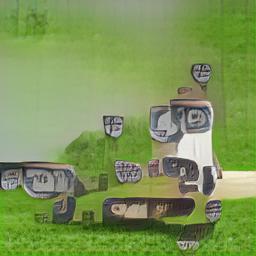

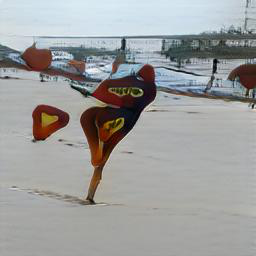

In [633]:
display(Image.fromarray(haiku_image))
display(Image.fromarray(seed_image))